In [1]:
import numpy as np
import astropy.constants as constant
import astropy.units as u
import matplotlib.pyplot as plt

In [2]:
M_sun = constant.M_sun.cgs.value
c = constant.c.cgs.value
def v_to_lam(v):
    #Input frequency v in Hz.
    #Return Wavelength in cm.

    return(c/v)
    
def find_tau_v(v, Mi=-23, M_BH=1e9 * M_sun):
    #Input frequency v in Hz, i band magnitude (default is -23), Black whole mass in g (defalt is 10^9 solar mass).
    #Return timescale in s.
    
    A = 2.4
    B = 0.17
    C = 0.03
    D = 0.21
                            #add C, D, BH_mass, Mi
    return 10 ** (A + B * np.log10(v_to_lam(v)/(4000e-8)) 
                  + C * (Mi + 23) + D * np.log10(M_BH/(1e9 * M_sun)))  #e-8 angstrom

                                  
def find_sf_inf(v, Mi=-23, M_BH=1e9 * M_sun):
    # Input frequency in Hz, i band magnitude (default is -23), Black whole mass in g (defalt is 10^9 solar mass).
    # Return Structure Function at infinity.

    A = -0.51
    B = -0.479
    C = 0.13
    D = 0.18
             
    return 10 ** (A + B * np.log10(v_to_lam(v)/(4000e-8))
                  + C * (Mi + 23) + D * np.log10(M_BH/(1e9 * M_sun)))

def prep_drw(v,  Mi=-23, M_BH=1e9 * M_sun):
    # Input frequency series, i band magnitude (default is -23),black whole mass in g (defalt is 10^9 solar mass).
    # Return Structure Function(infinity) array, and time scale array.
    
    sf_inf = find_sf_inf(v, Mi, M_BH)
    tau = find_tau_v(v, Mi, M_BH)
    
    return sf_inf, tau
    


def drw(t, v, sf_inf, tau, Mi=-23, M_BH=1e9 * M_sun, rng=None):
    # Input time moment as an array, discrete frequencies in array, i band magnitude (default is -23), 
    #black whole mass in g (defalt is 10^9 solar mass), random seed rng (default is None). 
    # Return 2D array x for Damped Random Walk at given time moments and frequencies. x[:,1] varies with frequency
    #x[1,:] varies with time.
    
    dt = np.diff(t)
    rng = np.random.default_rng(rng)
    r = rng.normal(size=t.size)
    x = np.zeros((t.size, v.size))   
#     sf_inf = find_sf_inf(v, Mi, M_BH)
#     tau = find_tau_v(v, Mi, M_BH)

    x[0] = r[0] * sf_inf

    for i in range(1, np.size(t)):
        x[i] = (x[i-1] * np.exp(-dt[i-1]/tau) 
                + sf_inf * np.sqrt(1 - np.exp(-2*dt[i-1]/tau)) * r[i])    #use expm1 instead for 1-exp
    return x

def baseline(v):
    # Input frequency as array.
    # Return baseline (average value).
    
    return v**(1/3)

def mag_to_flux(mag, base):
    # Input magnitude and baseline (average value).
    # Return flux.
    
    return base * 10**(-0.4*mag)

In [3]:
# testing example with random time series, frequencies in IR band


t_test = np.random.normal(0, 300, 100)
# t_test = np.random.uniform(1, 1000, [100])
t_test.sort()

lam = np.linspace(3000e-8, 10000e-8, 100)
v = c/lam
# v = np.arange(1e9, 1e18, 1e16) # other testing frequencies


start_index = 2
rng = np.random.default_rng(start_index)
sf_inf, tau = prep_drw(v,Mi=-23, M_BH=1e9*M_sun)

# %timeit walks = drw(x_0=1, t=t_test, v = v, rng=rng)
walks = drw(t=t_test, v=v, sf_inf=sf_inf, tau=tau, Mi=-23, M_BH=1e9*M_sun, rng=rng)

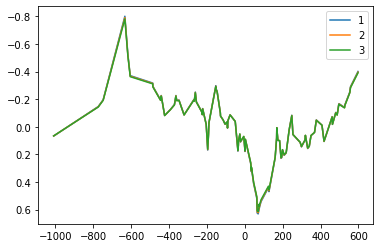

In [4]:
# Plot result for testing example before adding baseline. x-axis is time. Different labels stand for different frequencies.
plt.plot(t_test, walks[:,0], label='1')
plt.plot(t_test, walks[:,1], label='2')
plt.plot(t_test, walks[:,2], label='3')
plt.legend()
plt.gca().invert_yaxis()

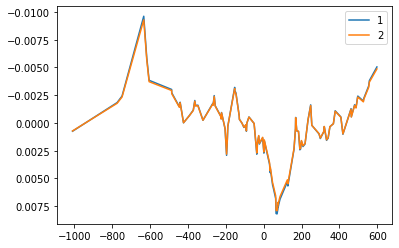

In [5]:
# Plot result for testing example before adding baseline. x-axis is time. y-axis is the difference between two neighbors.
#Different labels stand for different frequencies.

plt.plot(t_test, walks[:,0]-walks[:,1], label='1')
plt.plot(t_test, walks[:,1]-walks[:,2], label='2')
plt.legend()
plt.gca().invert_yaxis()
# plt.plot(t_test, walks[:,2], label='3')

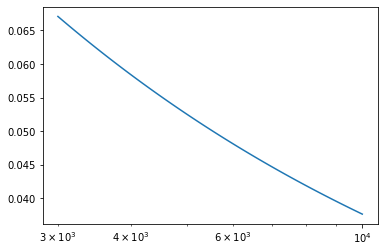

In [6]:
# Plot result for testing example before adding baseline. x-axis is frequency.
plt.plot(lam*1e8, walks[0,:], label='1')
plt.xscale('log')

In [7]:
# Adding baseline
base = baseline(v)
flux = mag_to_flux(walks[0,:],base)
flux_2 = mag_to_flux(walks[-1,:],base)
flux_3 = mag_to_flux(walks[3,:],base)

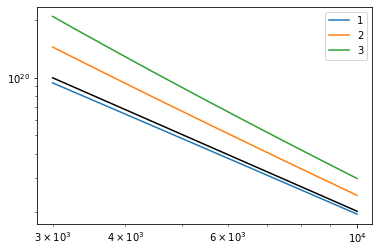

In [8]:
# Plot result for testing example after adding baseline. x-axis is wavelength. y-axis is flux * frequency
#Different labels stand for different time moments. Black curve is the baseline.


plt.plot(lam*1e8, base*v, c='black')
plt.plot(lam*1e8, flux*v, label='1')
plt.plot(lam*1e8, flux_2*v, label='2')
plt.plot(lam*1e8, flux_3*v, label='3')    #vFv, energy part
plt.legend()
plt.xscale('log')
plt.yscale('log')

Text(0.5, 1.0, 'different BH mass')

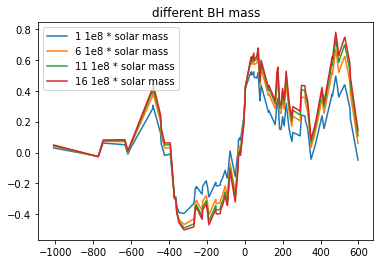

In [13]:
# compare different M_BH
walks_M_BH = []
rng = 0
for i in range(20):
    sf_inf, tau = prep_drw(v,  Mi=-23, M_BH=(i+1) * 1e8*M_sun)
    walks_M_BH.append(drw(t=t_test, v = v, Mi=-23, sf_inf=sf_inf, tau=tau, M_BH=(i+1) * 1e8*M_sun, rng=rng))
    
for i in range(0,20, 5):
    
    plt.plot(t_test, walks_M_BH[i][:,0], label=f'{(i+1)} 1e8 * solar mass')
    
plt.legend()
plt.title('different BH mass')

Text(0.5, 1.0, 'different Mi')

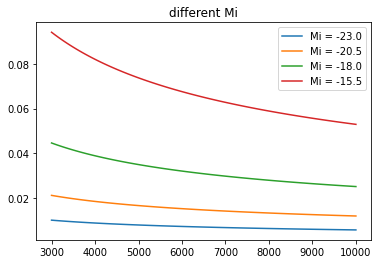

In [14]:
# compare different Mi
walks_Mi = []
rng = 0
for i in range(-10,10):
    sf_inf, tau = prep_drw(v,  Mi=-23 + 0.5*i)
    walks_Mi.append(drw(t=t_test, v = v,sf_inf=sf_inf, tau=tau, Mi=-23 + 0.5*i, M_BH=1e9*M_sun, rng=rng))


for i in range(0,20, 5):
    
    plt.plot(lam*1e8, walks_Mi[i][0,:], label=f'Mi = {-23 + 0.5*i}')
    
plt.legend()
plt.title('different Mi')

In [ ]:
# imclude C, D to equations; change black hole mass etc and how they chagne SED
# check all equations;debug 
# SNANA finish the login, connect to SNANA, python code about model, pysedmodel.py


In [ ]:
#citation for the coefficient, check with paper
#debug: move to some script. write test. 1. regression 
#2. Run multiple different rng, collect x(0)s,
# and x(t)s Dispersion D(x(0)-x(t)) -- 2 * SFinf^2
# or cov(x(0), x(ti)) -- 2 * SFinf * (1 - e^(-2ti/tao))

# learn build c code inside SNANA directory
# learn simulation in an interactive way, ask Kostya for example
# ask colin about the code
# check the visa
# ask about github